In [40]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


In [41]:
# Directory containing processed files
data_folder = "processed_data"

# Function to preprocess MIP data by merging consecutive seasons
def preprocess_mip_data(current_season, previous_season):
    # Merge current and previous season data
    df_combined = pd.merge(
        current_season,
        previous_season,
        on='Player',
        suffixes=('_curr', '_prev')
    )
    
    # Calculate year-over-year improvements
    df_combined['PTS_improvement'] = df_combined['PTS_curr'] - df_combined['PTS_prev']
    df_combined['TRB_improvement'] = df_combined['TRB_curr'] - df_combined['TRB_prev']
    df_combined['AST_improvement'] = df_combined['AST_curr'] - df_combined['AST_prev']
    
    # Compute overall improvement score
    df_combined['Improvement_Score'] = (
        df_combined['PTS_improvement'] +
        df_combined['TRB_improvement'] +
        df_combined['AST_improvement']
    )
    return df_combined


In [42]:
# Function to preprocess multiple seasons
def preprocess_all_seasons(data_folder, start_year, end_year):
    season_files = [f"{data_folder}/nba_player_stats_{year}-{str(year+1)[-2:]}_processed.csv" for year in range(start_year, end_year)]
    processed_dfs = []
    
    for i in range(1, len(season_files)):
        current_file = season_files[i]
        previous_file = season_files[i - 1]
        
        if os.path.exists(current_file) and os.path.exists(previous_file):
            current_season = pd.read_csv(current_file)
            previous_season = pd.read_csv(previous_file)
            
            processed_df = preprocess_mip_data(current_season, previous_season)
            processed_dfs.append(processed_df)
        else:
            print(f"Files {current_file} or {previous_file} not found. Skipping.")
    
    return pd.concat(processed_dfs, ignore_index=True)

In [43]:

# Preprocess training and testing datasets
train_df = preprocess_all_seasons(data_folder, 1980, 2015)
test_df = preprocess_all_seasons(data_folder, 2016, 2024)

# Debug: Check columns
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)

# Function to mark top-5 MIP candidates per season
def mark_mip_candidates(df):
    df['MIP_Class'] = 0
    for season in df['Season_curr'].unique():
        season_mask = df['Season_curr'] == season
        season_data = df[season_mask]
        top_5_indices = season_data.nlargest(5, 'Improvement_Score').index
        df.loc[top_5_indices, 'MIP_Class'] = 1
    return df

Columns in train_df: Index(['Player', 'Team_curr', 'G_curr', 'MP_curr', 'FG_curr', 'FGA_curr',
       'FG%_curr', '3P_curr', '3P%_curr', '2P_curr', '2P%_curr', 'eFG%_curr',
       'FT_curr', 'FTA_curr', 'FT%_curr', 'ORB_curr', 'DRB_curr', 'TRB_curr',
       'AST_curr', 'STL_curr', 'BLK_curr', 'TOV_curr', 'PTS_curr',
       'Season_curr', 'TS%_curr', 'EFF_curr', 'MVP_Rank_curr',
       'Nominated_curr', 'Team_prev', 'G_prev', 'MP_prev', 'FG_prev',
       'FGA_prev', 'FG%_prev', '3P_prev', '3P%_prev', '2P_prev', '2P%_prev',
       'eFG%_prev', 'FT_prev', 'FTA_prev', 'FT%_prev', 'ORB_prev', 'DRB_prev',
       'TRB_prev', 'AST_prev', 'STL_prev', 'BLK_prev', 'TOV_prev', 'PTS_prev',
       'Season_prev', 'TS%_prev', 'EFF_prev', 'MVP_Rank_prev',
       'Nominated_prev', 'PTS_improvement', 'TRB_improvement',
       'AST_improvement', 'Improvement_Score'],
      dtype='object')
Columns in test_df: Index(['Player', 'Team_curr', 'G_curr', 'MP_curr', 'FG_curr', 'FGA_curr',
       'FG%_curr', '3P_c

In [44]:


# Marking MIP candidates in both datasets
train_df = mark_mip_candidates(train_df)
test_df = mark_mip_candidates(test_df)

print("Training Data MIP_Class Distribution:")
print(train_df['MIP_Class'].value_counts(normalize=True))

# Defining features and labels
features = ['PTS_improvement', 'TRB_improvement', 'AST_improvement', 'Improvement_Score']
X = train_df[features]
y = train_df['MIP_Class']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, stratify=y)

# Handling missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns
)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Handling class imbalance with SMOTE
class_counts = y_train.value_counts()
print(f"Class distribution before SMOTE: {class_counts}")

minority_class_size = class_counts[1]
if minority_class_size > 1:
    k_neighbors = min(5, minority_class_size - 1)
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    print(f"Class distribution after SMOTE: {pd.Series(y_train_balanced).value_counts()}")
else:
    print("Not enough samples in the minority class for SMOTE. Skipping oversampling.")
    X_train_balanced, y_train_balanced = X_train_scaled, y_train

# Training a DummyClassifier
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_balanced, y_train_balanced)




Training Data MIP_Class Distribution:
MIP_Class
0    0.985371
1    0.014629
Name: proportion, dtype: float64
Class distribution before SMOTE: MIP_Class
0    9160
1     136
Name: count, dtype: int64
Class distribution after SMOTE: MIP_Class
0    9160
1    9160
Name: count, dtype: int64


DummyClassifier(random_state=42, strategy='stratified')

In [45]:
# Predict MIP candidates for 2023–24
season_2024 = test_df[test_df['Season_curr'] == '2023-24'].copy()

if season_2024.empty:
    print("No data available for the 2023–24 season.")
else:
    X_2024 = season_2024[features]
    
    # Preprocessing the 2023–24 data
    X_2024_imputed = pd.DataFrame(imputer.transform(X_2024), columns=X_2024.columns)
    X_2024_scaled = scaler.transform(X_2024_imputed)
    
    # Getting predictions
    pred_proba = dummy_clf.predict_proba(X_2024_scaled)[:, 1]
    season_2024['MIP_Probability'] = pred_proba
    
    # Show the top 5 predictions
    top_5 = season_2024.nlargest(5, 'MIP_Probability')[
        ['Player', 'Team_curr', 'MIP_Probability', 'PTS_improvement', 'TRB_improvement', 'AST_improvement', 'Improvement_Score']
    ]
    print("\nTop 5 Predicted MIP Candidates for 2023–24 Season:")
    print(top_5.round(3))
    
    # Predict and print the Most Improved Player
    mip_winner = top_5.iloc[0]  # Get the player with the highest probability
    print("\nPredicted Most Improved Player for 2023–24:")
    print(f"Player: {mip_winner['Player']}")
    print(f"Team: {mip_winner['Team_curr']}")
    print(f"Probability: {mip_winner['MIP_Probability']:.3f}")
    print(f"PTS Improvement: {mip_winner['PTS_improvement']}")
    print(f"TRB Improvement: {mip_winner['TRB_improvement']}")
    print(f"AST Improvement: {mip_winner['AST_improvement']}")


# Evaluate the model
y_pred = dummy_clf.predict(scaler.transform(imputer.transform(X_val)))
print("\nValidation Set Performance:")
print(f"Recall Score: {recall_score(y_val, y_pred):.3f}")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_pred):.3f}")




Top 5 Predicted MIP Candidates for 2023–24 Season:
             Player Team_curr  MIP_Probability  PTS_improvement  \
2682    Joel Embiid       PHI              1.0              1.6   
2686  Jalen Brunson       NYK              1.0              4.7   
2687   Devin Booker       PHO              1.0             -0.7   
2688   Kevin Durant       PHO              1.0             -2.0   
2692  Stephen Curry       GSW              1.0             -3.0   

      TRB_improvement  AST_improvement  Improvement_Score  
2682              0.8              1.4                3.8  
2686              0.1              0.5                5.3  
2687              0.0              1.4                0.7  
2688             -0.1              0.0               -2.1  
2692             -1.6             -1.2               -5.8  

Predicted Most Improved Player for 2023–24:
Player: Joel Embiid
Team: PHI
Probability: 1.000
PTS Improvement: 1.6000000000000014
TRB Improvement: 0.8000000000000007
AST Improvement: 1.

c:\Users\ethan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


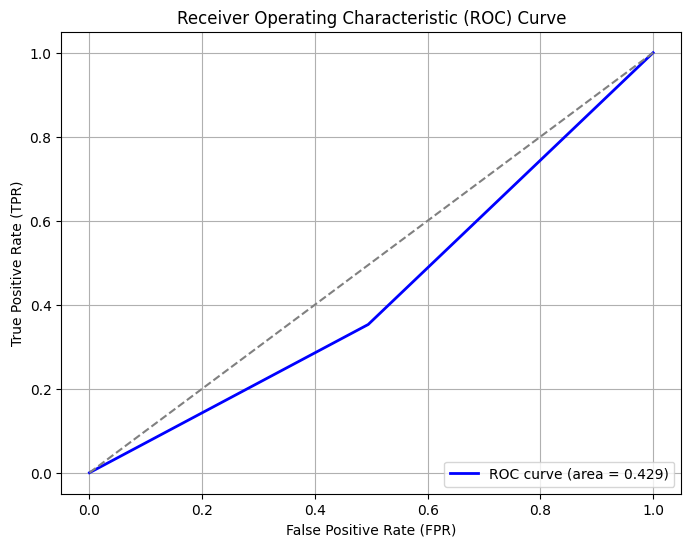

In [46]:
# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()